In [485]:
import numpy as np
import matplotlib.pyplot as plt
from dolfin import *
from mshr import *

In [514]:
def initialize_and_run(Voltage = 8,num_steps = 10):
    # Create mesh and define function space
    nx = ny = nz = 32
    mesh = UnitSquareMesh(nx,ny)
    #mesh = generate_mesh(Rectangle(Point(0, 0), Point(10.0, 1.0)),320,32)
    mesh = RectangleMesh(Point(0,0), Point(10, 1), 320, 32, "right/left")
    P1 = FiniteElement('P', triangle, 1)
    V1 = VectorElement('P', triangle, 1)
    # element  = P1*P1*P1*P1*V1*V1
    """
    The function space is : \rho_1,\rho_2,\phi,T,u_1,u_2

    """
    element = MixedElement([P1, P1, P1, P1, V1, V1])
    V = FunctionSpace(mesh, element)
    VV = FunctionSpace(mesh,P1)
    VVV = FunctionSpace(mesh,V1)
    #v_1, v_2, v_3 , v_4 , v_5 ,v_6= TestFunctions(V)

    v_1 = TestFunction(VV)
    v_2 = TestFunction(VV)
    v_3 = TestFunction(VV)
    v_4 = TestFunction(VV)
    v_5 = TestFunction(VVV)
    v_6 = TestFunction(VVV)

    #u = Function(V)
    #u_1, u_2, u_3, u_4, u_5, u_6 = split(u)


    u_1 = Function(VV)
    u_2 = Function(VV)
    u_3 = TrialFunction(VV)
    u_4 = Function(VV)


    # time step
    dt = 0.01
    delta = 0.5
    Cv = 300
    z = 1
    e = 1
    mu_1 = Constant(1.334)
    mu_2 = Constant(2.032)
    kB = 1
    epsilon = 1
    k = 300
    q_1 = 1
    q_2= -1

    num_steps = num_steps
    tol = 1E-14

    # mark the boundaries
    boundary_markers = FacetFunction('size_t', mesh)
    
    class BoundaryXmi(SubDomain):
        tol = 1E-14
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 5, tol)
    
    class BoundaryX1(SubDomain):
        tol = 1E-14
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 10, tol)
        
    class BoundaryX0(SubDomain):
        tol = 1E-14
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 0, tol)
    bx1 = BoundaryX1()
    bx1.mark(boundary_markers, 1)
    
    bx0 = BoundaryX0()
    bx0.mark(boundary_markers, 0)
    
    bxm = BoundaryXmi()
    bxm.mark(boundary_markers, 2)
    
    ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

    normal = FacetNormal(mesh)
    
    # define the dirichlet boundary for \phi

    phi_L = Constant(Voltage)
    def boundary_L(x, on_boundary):

        return on_boundary and near(x[0], 0, tol)

    bc_L = DirichletBC(VV, phi_L, boundary_L)


    phi_R = Constant(0)
    def boundary_R(x, on_boundary):

        return on_boundary and near(x[0], 10, tol)

    bc_R = DirichletBC(VV, phi_R, boundary_R)

    bcs = [bc_L, bc_R]

    '''
    later on when solving:

    solve(a == L, u, bcs)
    '''
    def boundary_rho(x,on_boundary):
        return on_boundary and (near(x[0],0,tol) or near(x[0],10,tol))

    rho_bc = Constant(-1)
    T_bc = Constant(0)
    bc_rho = DirichletBC(VV,rho_bc,boundary_rho)
    bc_T = DirichletBC(VV,T_bc,boundary_rho)
    # project the initial condition

    # Initial condition for temperature and species are all set to constant
    rho_1_0 = Constant(-1)
    rho_2_0 = Constant(-1)
    T_0 = Constant(0)

    class InitialCondition(Expression):
        def eval_cell(self, value, x, ufc_cell):
            #if x[0] <= 1.0:
            #   value[0] = 1.0
            #else:
            value[0] = 16*sin(x[0]*4)*cos(x[1]*4)+20

    class tempInitialCondition(Expression):

        def eval_cell(self, value, x, ufc_cell):
            value[0] = x[0]**2-x[1]**2+10


    u_n_4 = project(T_0,VV)
    #u_n_4 = Function(VV)
    #u_n_4.interpolate(tempInitialCondition())
    phi_n = project(phi_L,VV)
    u_n_1 = project(rho_1_0,VV)
    #u_n_1.interpolate(InitialCondition())
    u_n_2 = project(rho_2_0,VV)
    #U_n_2.interpolate(InitialCondition())


    # Create VTK files for visualization output
    vtkfile_u_1 = File('reaction_system/u_1.pvd')


    # Create progress bar
    progress = Progress('Time-stepping')
    set_log_level(PROGRESS)

    T = 1
    t = 0.0
    # The entropy and dissipation
    S = np.zeros(num_steps)
    Diss = np.zeros(num_steps)
    flux = np.zeros(num_steps)
    for n in range(num_steps):
        t +=dt

        # First solve the poisson equation

        # \phi equation
        u = TrialFunction(VV)
        v = TestFunction(VV)

        F  = epsilon*inner(nabla_grad(u), nabla_grad(v))*dx-q_1*exp(u_n_1)*v*dx-q_2*exp(u_n_2)*v*dx
        a,L = lhs(F),rhs(F)
        # Compute solution
        u = Function(VV)
        solve(a == L, u, bcs)
        # Plot solution and mesh

        phi_n.assign(u)

        # Then the continuity equations

        # \rho_1 equation
        #F_rho_1 = (1/dt)*exp(u_1)*v_1*dx-(1/dt)*exp(u_n_1)*v_1*dx+mu_1*dot(grad(exp(u_1+u_n_4)+q_1*phi_n),grad(v_1))*dx# not sure whether grad() can take this input
        F_rho_1 = (exp(u_1)*exp(u_n_4)*dot(grad(u_1),grad(v_1))+exp(u_1)*exp(u_n_4)*dot(grad(u_n_4),grad(v_1))+q_1*dot(grad(phi_n),grad(v_1)))*dx-(1/dt)*exp(u_n_1)*v_1*dx+(1/dt)*exp(u_1)*v_1*dx
        solve(F_rho_1==0,u_1,bc_rho)


        #F_rho_2 = -(1/dt)*(exp(u_n_2)-exp(u_2))*v_2*dx+exp(u_2)*exp(u_n_4)*dot(grad(u_2),grad(v_2))*dx+exp(u_2)*exp(u_n_4)*inner(grad(u_n_4),grad(v_2))*dx+q_1*dot(grad(phi_n),grad(v_2))*dx
        F_rho_2 = (exp(u_2)*exp(u_n_4)*dot(grad(u_2),grad(v_2))+exp(u_2)*exp(u_n_4)*dot(grad(u_n_4),grad(v_2))+q_2*dot(grad(phi_n),grad(v_2)))*dx-(1/dt)*exp(u_n_2)*v_2*dx+(1/dt)*exp(u_2)*v_2*dx
        solve(F_rho_2==0,u_2,bc_rho)

        # project the velocities
        u_n_5 = project((exp(u_n_4)*nabla_grad(u_n_4)+nabla_grad(u_1)*exp(u_n_4)+q_1*e*nabla_grad(phi_n))*mu_1,VVV) # velocity for species 1
        u_n_6 = project((exp(u_n_4)*nabla_grad(u_n_4)+nabla_grad(u_2)*exp(u_n_4)+q_2*e*nabla_grad(phi_n))*mu_2 ,VVV) # velocity for species 2

        #plot(exp(u_4))
        #plot(u_n_6)
        #plot(u_1)
        #plot(u_n_5)
        #plot(mesh)
        print t
        
        # Temperature equation

        F_T = (1/dt)*kB*(exp(u_1)+exp(u_2))*exp(u_4)*v_4*dx-(1/dt)*kB*(exp(u_1)+exp(u_2))*exp(u_n_4)*v_4*dx \
              -kB*exp(u_4)*dot(u_n_5,grad(u_n_1))*v_4*dx- kB*exp(u_4)*u_1*dot(u_n_5,grad(v_4))*dx \
            -kB*exp(u_4)*dot(u_n_6,grad(u_n_2))*v_4*dx- kB*exp(u_4)*u_2*dot(u_n_6,grad(v_4))*dx \
              +k*exp(u_4)*dot(grad(u_4),grad(v_4))*dx-(exp(u_1)*dot(u_n_5,u_n_5)/mu_1+exp(u_2)*dot(u_n_6,u_n_6)/mu_2)*v_4*dx 

        solve(F_T==0,u_4,bc_T)

        # Computing the functionals
        # including the entropy flux and heat flux
        Entropy = (exp(u_1)*(u_1-u_4-1)+exp(u_2)*(u_2-u_4-1))*dx 
        Flux = (exp(u_1)*(u_1-u_4-1)*dot(u_n_5,normal)+exp(u_2)*(u_2-u_4-1)*dot(u_n_6,normal))*ds(0)-\
                (exp(u_1)*(u_1-u_4-1)*dot(u_n_5,normal)+exp(u_2)*(u_2-u_4-1)*dot(u_n_6,normal))*ds(1)\
                -k*dot(grad(u_4),normal)*ds(0)-k*dot(grad(u_4),normal)*ds(1)
        #diss = k*dot(grad(u_4),grad(u_4))*dt*dx
        diss = dt*(exp(u_1)*dot(u_n_5,u_n_5)/(exp(u_4)*mu_1)+exp(u_2)*dot(u_n_6,u_n_6)/(exp(u_4)*mu_2)+k*dot(grad(u_4),grad(u_4)))*dx
        S[n] = assemble(Entropy)
        flux[n] = assemble(dt*Flux)
        Diss[n] = assemble(diss)
        '''
        if n>0:
            Diss[n] = assemble(diss)+Diss[n-1]
        else:
            Diss[n] = assemble(diss)
        '''
        I = (exp(u_1)*dot(u_n_5,normal)*q_1+exp(u_2)*dot(u_n_6,normal)*q_2)*ds(0)
        print assemble(I)
        
        # update the values
        u_n_1.assign(u_1)
        u_n_2.assign(u_2)
        u_n_4.assign(u_4)

        # Save solution to file (VTK)
        vtkfile_u_1 << (u_1, t)
        # Update progress bar
        progress.update(t/T)

    
    return Diss,S,assemble(I),u_1,u_2,u_4,flux,mesh

In [515]:
Diss,S,I,u_1,u_2,u_4,flux,mesh = initialize_and_run()

0.01
Calling FFC just-in-time (JIT) compiler, this may take some time.
0.990625759184
0.02
0.99192583331
0.03
0.992523498709
0.04
0.992914511838
0.05
0.993183272621
0.06
0.993369399671
0.07
0.993497696746
0.08
0.993585184851
0.09
0.993643844865
0.1
0.993682162793


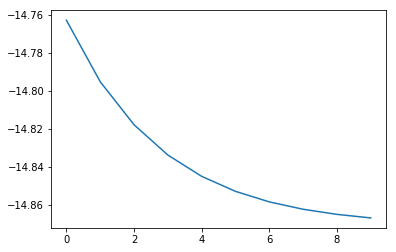

In [516]:
from matplotlib import pyplot as plt

plt.plot(S)


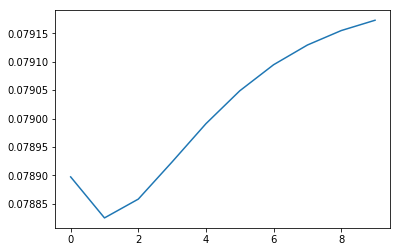

In [517]:
plt.plot(Diss)

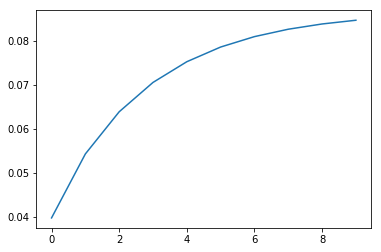

In [518]:
plt.plot(flux)

In [492]:
# Plot function
xvals = []
yvals  =[]
U = []
for v in vertices(mesh):
    x = v.point().x()
    y = v.point().y()
    xvals.append(x)
    yvals.append(y)
    U.append(exp(u_4(x, y)))

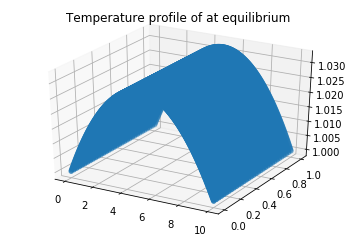

In [493]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xvals, yvals, U)
plt.title('Temperature profile of at equilibrium')
plt.show()
#plt.savefig('temperatrue.png')

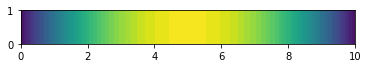

In [491]:
plot(exp(u_4))

NameError: name 'Z' is not defined

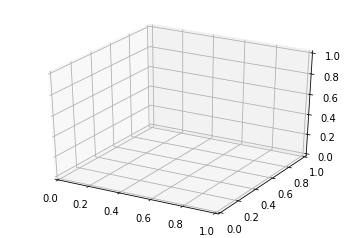

In [177]:
X = np.arange(0, 1, 0.03125)
Y = np.arange(0, 1, 0.03125)
X, Y = np.meshgrid(X, Y)
X, Y = np.meshgrid(X, Y)
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

8.12801355923
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


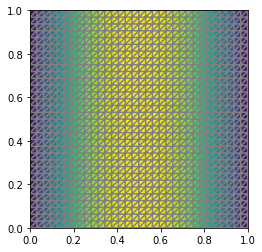

In [8]:
u_n_5 = project((exp(u_n_4)*nabla_grad(u_n_4)+nabla_grad(u_1)*exp(u_n_4)+q_1*e*nabla_grad(phi_n))*mu_1,VVV)
u_n_6 = project((exp(u_n_4)*nabla_grad(u_n_4)+nabla_grad(u_2)*exp(u_n_4)+q_2*e*nabla_grad(phi_n))*mu_2 ,VVV) 
print u_n_6.vector().max()

dt = 0.01


F_T = (1/dt)*kB*(exp(u_1)+exp(u_2))*(exp(u_4)-exp(u_n_4))*v_4*dx+k*exp(u_4)*dot(grad(u_4),grad(v_4))*dx-(exp(u_1)*dot(u_n_5,u_n_5)/mu_1+exp(u_2)*dot(u_n_6,u_n_6)/mu_2)*v_4*dx \
    -kB*exp(u_4)*dot((exp(u_4)*nabla_grad(u_4)+nabla_grad(u_1)*exp(u_4)+q_1*e*nabla_grad(phi_n))*mu_1,grad(u_1))*v_4*dx- kB*exp(u_4)*u_1*dot((exp(u_4)*nabla_grad(u_4)+nabla_grad(u_1)*exp(u_4)+q_1*e*nabla_grad(phi_n))*mu_1,grad(v_4))*dx \
    -kB*exp(u_4)*dot(u_n_6,grad(u_2))*v_4*dx- kB*exp(u_4)*u_2*dot(u_n_6,grad(v_4))*dx \

solve(F_T==0,u_4,bc_T)

plot(u_4)
plot(mesh)

In [72]:
print u_n_6.vector().max()

8.12801354566


## V-I curve

In [513]:
V_list = []
I_list = []
for V in range(1,6):
    Diss,S,I,u_1,u_2,u_4,flux,mesh = initialize_and_run(Voltage=V)
    V_list.append(V)
    I_list.append(I)

0.01
Calling FFC just-in-time (JIT) compiler, this may take some time.
0.0
0.02
0.0
0.03
0.0
0.04
0.0
0.05
0.0
0.06
0.0
0.07
0.0
0.08
0.0
0.09
0.0
0.1
0.0
0.01
0.0
0.02
0.0
0.03
0.0
0.04
0.0
0.05
0.0
0.06
0.0
0.07
0.0
0.08
0.0
0.09
0.0
0.1
0.0
0.01
0.0
0.02
0.0
0.03
0.0
0.04
0.0
0.05
0.0
0.06
0.0
0.07
0.0
0.08
0.0
0.09
0.0
0.1
0.0
0.01
0.0
0.02
0.0
0.03
0.0
0.04
0.0
0.05
0.0
0.06
0.0
0.07
0.0
0.08
0.0
0.09
0.0
0.1
0.0
0.01
0.0
0.02
0.0
0.03
0.0
0.04
0.0
0.05
0.0
0.06
0.0
0.07
0.0
0.08
0.0
0.09
0.0
0.1
0.0


In [511]:
plt.plot([0]+V_list,[0]+I_list)
#plt.plot(V_list,0.13*np.array(V_list))